In [1]:
import gymnasium as gym
import numpy as np
import os

from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv

from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3 import A2C, PPO, TD3

from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_vec_env

import matplotlib.pyplot as plt

import imageio

In [3]:
#plt.style.use('ggplot')
log_dir = "optimised/"


reward_target = 300
timestep_target = 1600
window_size = 100

fig1, (ax1_1, ax1_2) = plt.subplots(1, 2, figsize=(16,6)) # plot over window of  episodes

ax1_1.set_title("Episode Rewards")
ax1_1.axhline(y=reward_target, color = 'black', linestyle = 'dotted')
ax1_1.set_xlabel("Episodes")
ax1_1.set_ylabel("Rewards")
ax1_1.set_xlim([0, 5200])
ax1_1.set_ylim([-150, 350])
ax1_1.annotate("Target (higher is better)", (50, reward_target+6), fontsize=8)

ax1_2.set_title('Episode Length')
ax1_2.axhline(y=timestep_target, color = 'black', linestyle = 'dotted')
ax1_2.set_xlabel("Episodes")
ax1_2.set_ylabel("Duration of Episode (timesteps)")
ax1_2.set_xlim([0, 5200])
ax1_2.set_ylim([0, 1800])
ax1_2.annotate("Limit (lower is better)", (50, timestep_target + 20), fontsize=8)


fig2, (ax2_1, ax2_2) = plt.subplots(1, 2, figsize=(16,6)) # plot over timesteps

ax2_1.axhline(y=reward_target, color = 'black', linestyle = 'dotted')
ax2_1.set_xlim([0, 5000000])
ax2_1.set_xlabel("Timesteps")
ax2_1.set_ylabel("Episode rewards")
ax2_1.annotate("Target (higher is better)", (10000, reward_target+6), fontsize=8)

ax2_2.axhline(y=timestep_target, color = 'black', linestyle = 'dotted')
ax2_2.set_xlim([0, 5000000])
ax2_2.set_xlabel("Timesteps")
ax2_2.set_ylabel("Episode Durations")
ax2_2.annotate("Limit (lower is better)", (10000, timestep_target + 20), fontsize=8)


total_avg_reward = []
total_avg_timesteps = []
total_max_reward = []
total_max_timesteps = []

total_wall_clocks = []


for file in os.listdir(log_dir)[1:]:
    if ".csv" not in file:
        continue

    log_file_path = os.path.join(log_dir, file)

    rewards = []
    timesteps = []
    wall_clock_times = []
    with open(log_file_path, "r") as log_file:
        for line in log_file:
            if not line.startswith("#"):  # Skip comment lines
                try:
                    reward, time, wall_clock = [float(x) for x in line.split(",")[0:3]]  # Extract the reward value
                    #time = float(line.split(",")[1])

                    rewards.append(reward)
                    timesteps.append(time)
                    wall_clock_times.append(wall_clock)
                except:
                    #print("could not turn to float: ", line.split(",")[0])
                    #print("in file: ", log_file_path )
                    continue
    
    
    
    reward_averages = []
    timestep_averages = []
    iters = len(rewards) - window_size + 1
    reward_average = 0
    timestep_average = 1000000


    for i in range(0, iters):
        reward_average = round(sum(rewards[i : i + window_size]) / window_size, 2)
        timestep_average = round(sum(timesteps[i : i + window_size]) / window_size, 2)

        reward_averages.append(reward_average)
        timestep_averages.append(timestep_average)


    total_avg_reward.append(sum(reward_averages)/len(reward_averages))
    total_avg_timesteps.append(sum(timestep_averages)/len(timestep_averages))
    total_max_reward.append(max(reward_averages))
    total_max_timesteps.append(max(timestep_averages))
    total_wall_clocks.append(sum(wall_clock_times))

    # add this model's results to the plots
    # plots over window of episodes
    ax1_1.plot(range(0,iters), reward_averages, alpha=0.8, linewidth=1)
    
    ax1_2.plot(range(0,iters), timestep_averages, alpha=0.8, linewidth=1)
    

    #plt.show()
    
    # plots over timesteps
    ax2_1.scatter(np.cumsum(timesteps), rewards, s=2, alpha=0.5)
    ax2_2.scatter(np.cumsum(timesteps), timesteps, s=2, alpha=0.5)


fig1.savefig("plots/Optimised Episode Plots.png")
fig2.savefig("plots/Optimised Timestep Plots.png")

print("averaged over each model's training:")
print("                                Mean           STD")
print(f"average episode reward    ||   {np.mean(total_avg_reward):.3f}   ||    {np.std(total_avg_reward):.3f}")
print(f"average episode timesteps ||   {np.mean(total_avg_timesteps):.3f}  ||    {np.std(total_avg_timesteps):.3f}")
print(f"maximum episode reward    ||   {np.mean(total_max_reward):.3f}   ||    {np.std(total_max_reward):.3f}")
#print(f"maximum episode timesteps ||   {np.mean(total_max_timesteps):.3f}  ||    {np.std(total_max_timesteps):.3f}")

print(f"wall-clock time (5e6)     ||   {np.mean(total_wall_clocks):.3f}  ||    {np.std(total_wall_clocks):.3f}")

averaged over each model's training:
                                Mean           STD
average episode reward    ||   157.930   ||    9.551
average episode timesteps ||   1257.257  ||    89.350
maximum episode reward    ||   277.950   ||    7.390
wall-clock time (5e6)     ||   6262231.611  ||    556188.979


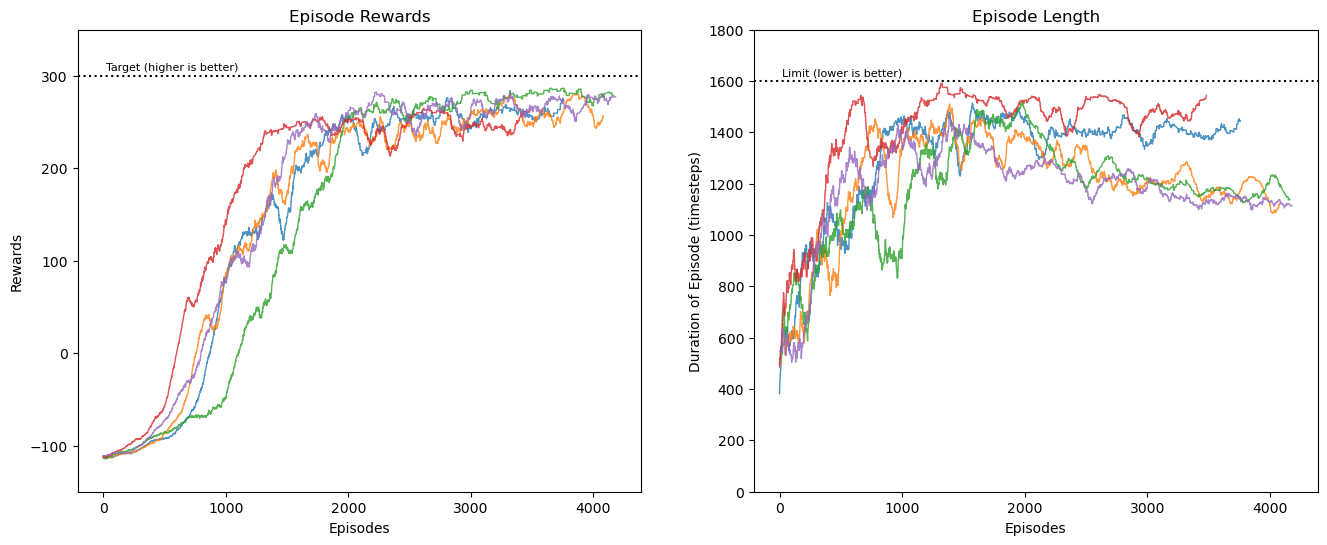

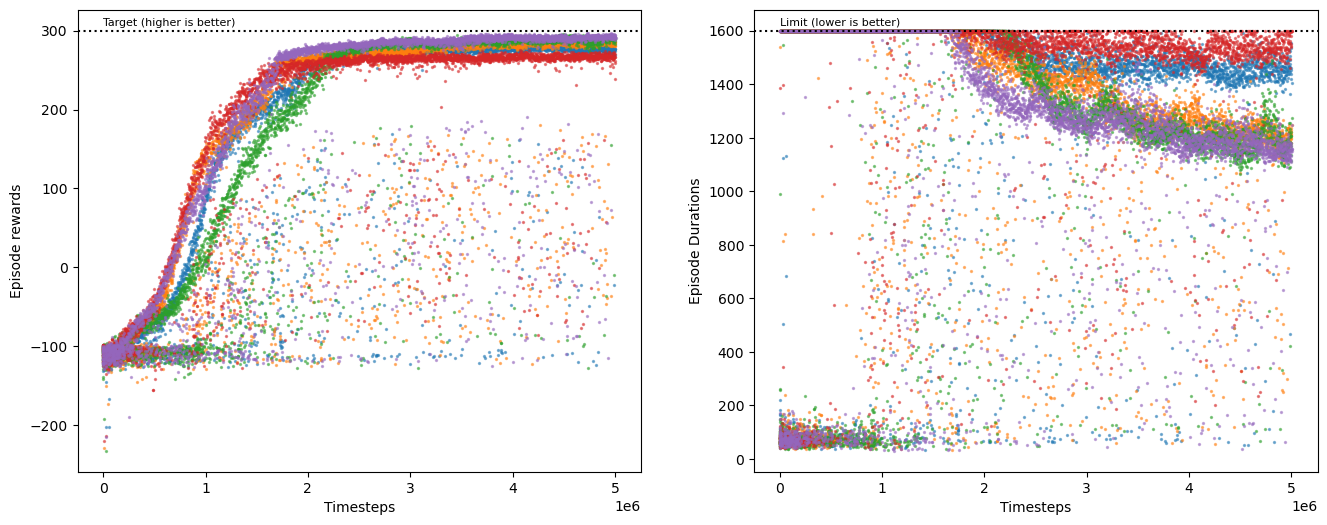

In [7]:
#plt.style.use('ggplot')
log_dir = "bests/"


reward_target = 300
timestep_target = 1600


fig, (ax1_1, ax1_2) = plt.subplots(1, 2, figsize=(16,6)) # plot over episodes

ax1_1.set_title("Episode Rewards")
ax1_1.axhline(y=reward_target, color = 'black', linestyle = 'dotted')
ax1_1.set_xlabel("Episodes")
ax1_1.set_ylabel("Rewards")
ax1_1.set_ylim([-150, 350])
ax1_1.annotate("Target (higher is better)", (20, reward_target+6), fontsize=8)

ax1_2.set_title('Episode Length')
ax1_2.axhline(y=timestep_target, color = 'black', linestyle = 'dotted')
ax1_2.set_xlabel("Episodes")
ax1_2.set_ylabel("Duration of Episode (timesteps)")
ax1_2.set_ylim([0, 1800])
ax1_2.annotate("Limit (lower is better)", (20, timestep_target + 20), fontsize=8)


fig2, (ax2_1, ax2_2) = plt.subplots(1, 2, figsize=(16,6)) # plot over timesteps

ax2_1.axhline(y=reward_target, color = 'black', linestyle = 'dotted')
#ax2_1.xlim([0, 5500000])
ax2_1.set_xlabel("Timesteps")
ax2_1.set_ylabel("Episode rewards")
ax2_1.annotate("Target (higher is better)", (20, reward_target+6), fontsize=8)

ax2_2.axhline(y=timestep_target, color = 'black', linestyle = 'dotted')
#ax2_2.xlim([0, 5500000])
ax2_2.set_xlabel("Timesteps")
ax2_2.set_ylabel("Episode Durations")
ax2_2.annotate("Limit (lower is better)", (20, timestep_target + 20), fontsize=8)


total_avg_reward = []
total_avg_timesteps = []
total_max_reward = []
total_max_timesteps = []

total_wall_clocks = []


for file in os.listdir(log_dir)[1:]:
    if ".csv" not in file:
        continue

    log_file_path = os.path.join(log_dir, file)

    rewards = []
    timesteps = []
    wall_clock_times = []
    with open(log_file_path, "r") as log_file:
        for line in log_file:
            if not line.startswith("#"):  # Skip comment lines
                try:
                    reward, time, wall_clock = [float(x) for x in line.split(",")[0:3]]  # Extract the reward value
                    #time = float(line.split(",")[1])

                    rewards.append(reward)
                    timesteps.append(time)
                    wall_clock_times.append(wall_clock)
                except:
                    continue
    
    window_size = 100
    reward_averages = []
    timestep_averages = []
    iters = len(rewards) - window_size + 1
    reward_average = 0
    timestep_average = 1000000


    for i in range(0, iters):
        reward_average = round(sum(rewards[i : i + window_size]) / window_size, 2)
        timestep_average = round(sum(timesteps[i : i + window_size]) / window_size, 2)

        reward_averages.append(reward_average)
        timestep_averages.append(timestep_average)


    total_avg_reward.append(sum(reward_averages)/len(reward_averages))
    total_avg_timesteps.append(sum(timestep_averages)/len(timestep_averages))
    total_max_reward.append(max(reward_averages))
    total_max_timesteps.append(max(timestep_averages))
    total_wall_clocks.append(sum(wall_clock_times))


    ax1_1.plot(range(0,iters), reward_averages, alpha=0.8, linewidth=1)
    ax1_2.plot(range(0,iters), timestep_averages, alpha=0.8, linewidth=1)

    ax2_1.scatter(np.cumsum(timesteps), rewards, s=2, alpha=0.5)
    ax2_2.scatter(np.cumsum(timesteps), timesteps, s=2, alpha=0.5)
    


print("averaged over each model's training:")
print("                                Mean           STD")
print(f"average episode reward    ||   {np.mean(total_avg_reward):.3f}   ||    {np.std(total_avg_reward):.3f}")
print(f"average episode timesteps ||   {np.mean(total_avg_timesteps):.3f}  ||    {np.std(total_avg_timesteps):.3f}")
print(f"maximum episode reward    ||   {np.mean(total_max_reward):.3f}   ||    {np.std(total_max_reward):.3f}")
#print(f"maximum episode timesteps ||   {np.mean(total_max_timesteps):.3f}  ||    {np.std(total_max_timesteps):.3f}")

print(f"wall-clock time (5e6)     ||   {np.mean(total_wall_clocks):.3f}  ||    {np.std(total_wall_clocks):.3f}")